# Resume Parsing

## 1. Load data

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [3]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [4]:
df_resume.shape

(2484, 4)

In [5]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [6]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [7]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [9]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [10]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
456,49486820,BENEFIT ADVOCATE Career Ove...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE
1265,34319869,GLOBAL DIGITAL SERVICING ~ DIGITAL ON...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
1925,82649935,SENIOR ACCOUNTANT Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT
1031,22047665,SALES MANAGER Summary Se...,"<div class=""fontsize fontface vmargins hmargin...",SALES
1749,16911115,BIOMEDICAL ENGINEERING TECHNICIAN II ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING


In [11]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [13]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         INTERIOR DESIGNER       Summary     Talented Designer and Retail Merchandiser skilled at using product placement and creating uniquely inspiring displays. Collaborates with company headquarters and sales managers to create product display solutions that boost sales revenue.       Highlights'

In [14]:
preprocessing(random_resume[:300])

'interior designer summary talented designer retail merchandiser skilled product placement create uniquely inspiring display collaborate company headquarters sale manager create product display solution boost sale revenue highlight'

In [15]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [16]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
456,49486820,BENEFIT ADVOCATE Career Ove...,"<div class=""fontsize fontface vmargins hmargin...",ADVOCATE,benefit advocate career overview customer serv...
1265,34319869,GLOBAL DIGITAL SERVICING ~ DIGITAL ON...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,global digital servicing digital onboarding co...
1925,82649935,SENIOR ACCOUNTANT Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,senior accountant summary a highly competent m...
1031,22047665,SALES MANAGER Summary Se...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sales manager summary service focus profession...
1749,16911115,BIOMEDICAL ENGINEERING TECHNICIAN II ...,"<div class=""fontsize fontface vmargins hmargin...",ENGINEERING,biomedical engineer technician ii professional...


## 4. Let's really extract skills!!

In [17]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [18]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [19]:
df_resume.Skills.iloc[0]

['knowledge base',
 'interaction',
 'database',
 'medium',
 'software',
 'search engine',
 'design',
 'support',
 'release',
 'business']

## 5. Visualization

Which skills is most important in information management?

In [21]:
# set(df_resume.Category)

In [22]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(44, 6)

In [23]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [25]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [26]:
counting

OrderedDict([('support', 41),
             ('software', 37),
             ('design', 36),
             ('business', 31),
             ('security', 28),
             ('server', 28),
             ('windows', 26),
             ('project management', 25),
             ('database', 22),
             ('documentation', 19)])

<BarContainer object of 10 artists>

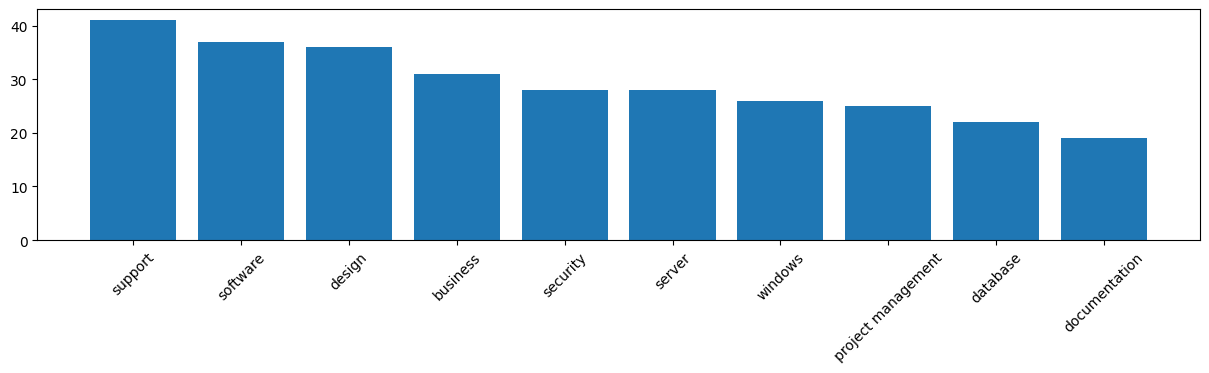

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [28]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [29]:
doc = nlp(text)

In [32]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [33]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [34]:
text = preprocessing(text)

In [36]:
doc = nlp(text)

In [37]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)